In [5]:
import sys
print(f'Interpreter dir: {sys.executable}')
import os

if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('../')
    
print(f'Working dir: {os.getcwd()}')
%load_ext autoreload
%autoreload 2

Interpreter dir: c:\users\sesma\water_hackathlon\.venv_waterhack\scripts\python.exe
Working dir: C:\Users\sesma\water_hackathlon


In [6]:
import pandas as pd
from pandas_profiling import ProfileReport
pd.set_option('display.max_rows', 200)
import numpy as np
import pandas_profiling

# Explore AW dataset

In [7]:
# Leemos el archivo
df_DMAleaks = pd.read_csv('data/raw/DMALeaks.csv')
df_DMAleaks
# Hay comas extra en los datos (2020-05-15 07:50:10,Washout(Fixed On Site),,NEWCENMA). Para corregirlo generamos una columna
# de nombre AUX para, posteriormente, hacer un merge y así corregir el defecto.

,DateRaised,LeakType,DMAName,AUX
0,2018-11-19 12:13:21,Other Repaired Leaks,NEWCENMA,NaN
1,2018-02-12 20:39:37,BurstMain,NORCRDMA,NaN
2,2020-08-13 10:43:46,BTBB,NORW37MA,NaN
3,2017-02-24 08:39:14,Other Repaired Leaks,NEWSEVMA,NaN
4,2019-02-21 12:26:52,Stop Tap/ Atplas (Fix On Site),NEWSEVMA,NaN
...,...,...,...,...
703,2020-05-15 07:50:10,Washout (Fixed On Site),NaN,NEWCENMA
704,2020-07-22 12:03:48,Comm Pipe (before ST),NaN,NEWSEVMA
705,2018-12-10 11:43:13,Stop Tap / Atplas,NEWCENMA,NaN
706,2019-08-09 14:37:52,BTBB,NEWSEVMA,NaN


In [8]:
print(df_DMAleaks.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 708 entries, 0 to 707
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   DateRaised  708 non-null    object
 1   LeakType    708 non-null    object
 2   DMAName     510 non-null    object
 3   AUX         204 non-null    object
dtypes: object(4)
memory usage: 22.2+ KB
None


In [9]:
# Convertimos el formato DateRaised utilizandoel atributo .to_datetime
# To timestamp
df_DMAleaks['DateRaised'] = pd.to_datetime(df_DMAleaks.DateRaised)

In [10]:
print(df_DMAleaks.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 708 entries, 0 to 707
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   DateRaised  708 non-null    datetime64[ns]
 1   LeakType    708 non-null    object        
 2   DMAName     510 non-null    object        
 3   AUX         204 non-null    object        
dtypes: datetime64[ns](1), object(3)
memory usage: 22.2+ KB
None


In [11]:
# There are extra commas :/ lets merge extra column. El merge se lleva a cabo con el atributo combine_first.
# combine_first completa, en este caso, la columna DMAName con los valores que le faltan y que existen en AUX.
df_DMAleaks['DMAName'] = df_DMAleaks['DMAName'].combine_first(df_DMAleaks['AUX'])
df_DMAleaks = df_DMAleaks.drop('AUX', axis=1)
df_DMAleaks

,DateRaised,LeakType,DMAName
0,2018-11-19 12:13:21,Other Repaired Leaks,NEWCENMA
1,2018-02-12 20:39:37,BurstMain,NORCRDMA
2,2020-08-13 10:43:46,BTBB,NORW37MA
3,2017-02-24 08:39:14,Other Repaired Leaks,NEWSEVMA
4,2019-02-21 12:26:52,Stop Tap/ Atplas (Fix On Site),NEWSEVMA
...,...,...,...
703,2020-05-15 07:50:10,Washout (Fixed On Site),NEWCENMA
704,2020-07-22 12:03:48,Comm Pipe (before ST),NEWSEVMA
705,2018-12-10 11:43:13,Stop Tap / Atplas,NEWCENMA
706,2019-08-09 14:37:52,BTBB,NEWSEVMA


In [12]:
# Agrupamos por columna DMAName unido al atributo count y así contar el número de veces para cada DMAName, encontramos tres entradas erróneas
# que Javi a corregido manualmente.
df_DMAleaks.groupby('DMAName').count()

,DateRaised,LeakType
DMAName,,
"<12"" (300mm)",2,2
and above,2,2
not BTBB),2,2
BLOFLDMA,51,51
NEWCENMA,159,159
NEWSEVMA,247,247
NEWSTUMA,27,27
NORCRDMA,22,22
NORFIFMA,39,39


- Something is funny with a couple of entries, due to an extra comma in the LeakType - fixed manually

# Prepare a dataset for classification problem

The target is the leakage at DMA level, which is a binary variable. We can organize the work as follows:
1. Find the times when a leakage was raised. Mark with 1
2. Add a new column, with a few hours ebfore and after that indicates is_leakage
3. We can predict that, or we can predict a (probabbly( easier target one that says "There is a leakage today"

On the features side, we need to align:
- Inflow
- Pressure
- ...
- Feature engineered columns (past values, moving average, ...)

# Prepare features dataset

In [13]:
df_p = pd.read_csv('data/raw/DMA15MinPressure.csv')
# To Timestamp
df_p['Timestamp'] = pd.to_datetime(df_p.Timestamp)

print(df_p.info())
df_p

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005975 entries, 0 to 1005974
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   DMA        1005975 non-null  object        
 1   Timestamp  1005975 non-null  datetime64[ns]
 2   Value      1005975 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 23.0+ MB
None


,DMA,Timestamp,Value
0,BLOFLDMA,2019-03-25 00:00:00,4.952223
1,BLOFLDMA,2019-03-25 00:15:00,4.854159
2,BLOFLDMA,2019-03-25 00:30:00,4.805128
3,BLOFLDMA,2019-03-25 00:45:00,4.952223
4,BLOFLDMA,2019-03-25 01:00:00,4.903191
...,...,...,...
1005970,SWALSHMA,2020-07-31 23:00:00,0.000000
1005971,SWALSHMA,2020-07-31 23:15:00,0.000000
1005972,SWALSHMA,2020-07-31 23:30:00,0.000000
1005973,SWALSHMA,2020-07-31 23:45:00,0.000000


In [14]:
df_inf = pd.read_csv('data/raw/DMA15MinNetFLow.csv')
df_inf['ReferenceTimestamp'] = pd.to_datetime(df_inf.ReferenceTimestamp)

print(df_inf.info())
df_inf

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1348712 entries, 0 to 1348711
Data columns (total 3 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   DMA                 1348712 non-null  object        
 1   ReferenceTimestamp  1348712 non-null  datetime64[ns]
 2   m3Volume            1348712 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 30.9+ MB
None


,DMA,ReferenceTimestamp,m3Volume
0,NORW21MA,2016-12-01 00:00:00,8.094000
1,NORW21MA,2016-12-01 00:15:00,7.343000
2,NORW21MA,2016-12-01 00:30:00,6.684000
3,NORW21MA,2016-12-01 00:45:00,6.835000
4,NORW21MA,2016-12-01 01:00:00,6.220000
...,...,...,...
1348707,NEWCENMA,2020-05-20 21:45:00,21.640001
1348708,NEWCENMA,2020-05-20 22:00:00,19.190001
1348709,NEWCENMA,2020-05-20 22:15:00,18.350000
1348710,NEWCENMA,2020-05-20 22:30:00,17.230001


In [15]:
# Lets merge both
df_m = pd.merge(df_p, df_inf, left_on=['DMA','Timestamp'], right_on=['DMA','ReferenceTimestamp'])
df_m.drop('ReferenceTimestamp', axis=1)

,DMA,Timestamp,Value,m3Volume
0,BLOFLDMA,2019-03-25 00:00:00,4.952223,3.54
1,BLOFLDMA,2019-03-25 00:15:00,4.854159,3.36
2,BLOFLDMA,2019-03-25 00:30:00,4.805128,3.06
3,BLOFLDMA,2019-03-25 00:45:00,4.952223,3.01
4,BLOFLDMA,2019-03-25 01:00:00,4.903191,2.98
...,...,...,...,...
943663,SWALSHMA,2020-05-31 23:00:00,0.000000,0.00
943664,SWALSHMA,2020-05-31 23:15:00,0.000000,0.00
943665,SWALSHMA,2020-05-31 23:30:00,0.000000,0.00
943666,SWALSHMA,2020-05-31 23:45:00,0.000000,0.00


In [16]:
# Herramienta para la exploración de datos
report = pandas_profiling.ProfileReport(df_m, progress_bar=False)

In [45]:
report.to_file("report.html")

c:\users\sesma\water_hackathlon\.venv_waterhack\lib\site-packages\pandas_profiling\visualisation\plot.py:154: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdBu"))
  cmap.set_bad(cmap_bad)


# Prepare target dataset

Convert the dataset df_DMAleaks into a time-series

In [17]:
# MErged dataset with leaks
# IMPORTANT: tolerance is set to 15 minutes, on the nearest. We select the 2 closes timestamps.
df_ml = pd.merge_asof(df_m.sort_values('Timestamp'),
                      df_DMAleaks.sort_values('DateRaised'),
                      left_by='DMA', right_by='DMAName',
                      left_on ="Timestamp", right_on="DateRaised",
                     tolerance = pd.Timedelta('15min'),
                     direction='nearest')
df_ml

,DMA,Timestamp,Value,ReferenceTimestamp,m3Volume,DateRaised,LeakType,DMAName
0,NEWSEVMA,2016-12-01,2.011256,2016-12-01,11.210,NaT,NaN,NaN
1,NORW21MA,2016-12-01,2.345946,2016-12-01,8.094,NaT,NaN,NaN
2,NEWSTUMA,2016-12-01,2.564902,2016-12-01,0.000,NaT,NaN,NaN
3,BURYRDMA,2016-12-01,2.208337,2016-12-01,2.650,NaT,NaN,NaN
4,NORW37MA,2016-12-01,2.514855,2016-12-01,2.791,NaT,NaN,NaN
...,...,...,...,...,...,...,...,...
943663,NORFIFMA,2020-06-01,0.000000,2020-06-01,3.375,NaT,NaN,NaN
943664,NORCRDMA,2020-06-01,1.698159,2020-06-01,2.077,NaT,NaN,NaN
943665,NEWSTUMA,2020-06-01,2.667152,2020-06-01,2.300,NaT,NaN,NaN
943666,NORW37MA,2020-06-01,2.570253,2020-06-01,1.598,NaT,NaN,NaN


In [31]:
df_ml['is_leakage'] = np.where(~df_ml.DateRaised.isna(),1,0)
df_mtograph = df_ml[df_ml['is_leakage'] == 1]
df_mtograph

,DMA,Timestamp,Value,ReferenceTimestamp,m3Volume,DateRaised,LeakType,DMAName,is_leakage
1002,NORW21MA,2016-12-02 17:45:00,2.421016,2016-12-02 17:45:00,18.810000,2016-12-02 17:50:30,Other Repaired Leaks,NORW21MA,1
1012,NORW21MA,2016-12-02 18:00:00,2.377225,2016-12-02 18:00:00,21.082000,2016-12-02 17:50:30,Other Repaired Leaks,NORW21MA,1
16421,NORW21MA,2016-12-29 12:00:00,2.274003,2016-12-29 12:00:00,18.418000,2016-12-29 12:00:36,BurstMain,NORW21MA,1
16422,NORW21MA,2016-12-29 12:15:00,2.198932,2016-12-29 12:15:00,17.577000,2016-12-29 12:00:36,BurstMain,NORW21MA,1
17858,NORW21MA,2017-01-01 00:00:00,2.314666,2017-01-01 00:00:00,11.732000,2017-01-01 00:09:25,BurstMain,NORW21MA,1
...,...,...,...,...,...,...,...,...,...
939102,NEWSEVMA,2020-05-27 16:15:00,1.991983,2020-05-27 16:15:00,30.110001,2020-05-27 16:11:35,Other Repaired Leaks,NEWSEVMA,1
940378,NEWCENMA,2020-05-28 21:15:00,2.479605,2020-05-28 21:15:00,23.090000,2020-05-28 21:22:02,BTBB (Low Level),NEWCENMA,1
940381,NEWCENMA,2020-05-28 21:30:00,2.504611,2020-05-28 21:30:00,23.200001,2020-05-28 21:22:02,BTBB (Low Level),NEWCENMA,1
943334,NEWSEVMA,2020-05-31 16:30:00,1.995109,2020-05-31 16:30:00,28.460002,2020-05-31 16:40:16,Other Repaired Leaks,NEWSEVMA,1


# Merge with weather data

In [19]:
df_weather = pd.read_csv('data/raw/Norwich_weather_Dec2016Jun2020.csv',parse_dates = ['date_time'])
print(df_weather.columns)
df_weather

Index(['date_time', 'maxtempC', 'mintempC', 'totalSnow_cm', 'sunHour',
       'uvIndex', 'moon_illumination', 'moonrise', 'moonset', 'sunrise',
       'sunset', 'DewPointC', 'FeelsLikeC', 'HeatIndexC', 'WindChillC',
       'WindGustKmph', 'cloudcover', 'humidity', 'precipMM', 'pressure',
       'tempC', 'visibility', 'winddirDegree', 'windspeedKmph', 'location'],
      dtype='object')


,date_time,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,moonrise,moonset,sunrise,...,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,location
0,2016-12-01 00:00:00,7,3,0.0,6.8,2,9,10:00 AM,06:42 PM,08:44 AM,...,35,54,95,0.0,1031,4,10,281,20,Norwich
1,2016-12-01 01:00:00,7,3,0.0,6.8,2,9,10:00 AM,06:42 PM,08:44 AM,...,35,55,95,0.0,1030,3,10,279,20,Norwich
2,2016-12-01 02:00:00,7,3,0.0,6.8,2,9,10:00 AM,06:42 PM,08:44 AM,...,35,57,95,0.0,1030,3,10,277,20,Norwich
3,2016-12-01 03:00:00,7,3,0.0,6.8,2,9,10:00 AM,06:42 PM,08:44 AM,...,35,58,95,0.0,1030,3,10,276,20,Norwich
4,2016-12-01 04:00:00,7,3,0.0,6.8,2,9,10:00 AM,06:42 PM,08:44 AM,...,35,62,95,0.0,1030,3,10,275,20,Norwich
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30691,2020-06-01 19:00:00,18,10,0.0,16.7,5,71,03:19 PM,02:58 AM,04:37 AM,...,23,8,82,0.0,1024,13,7,49,15,Norwich
30692,2020-06-01 20:00:00,18,10,0.0,16.7,5,71,03:19 PM,02:58 AM,04:37 AM,...,23,10,88,0.0,1024,12,5,43,13,Norwich
30693,2020-06-01 21:00:00,18,10,0.0,16.7,5,71,03:19 PM,02:58 AM,04:37 AM,...,24,11,94,0.0,1024,10,2,37,12,Norwich
30694,2020-06-01 22:00:00,18,10,0.0,16.7,5,71,03:19 PM,02:58 AM,04:37 AM,...,22,12,95,0.0,1024,10,2,36,11,Norwich


In [20]:
df_weather_sel = df_weather[['date_time', 'maxtempC', 'mintempC', 'totalSnow_cm',
                                 'sunHour','uvIndex', 'DewPointC', 'humidity',
                                 'precipMM', 'pressure','tempC']]

# Let's roudn the timestamps to the closets hour and then to the classical merge?
df_m2 = pd.merge_asof(df_ml,
                      df_weather_sel,
                      left_on='Timestamp',
                      right_on='date_time',
                      direction='nearest',
                      tolerance=pd.Timedelta('59min')
                     )
print(f"Shape df_ml:{df_ml.shape} Shape df_weather_sel: {df_weather_sel.shape} Shape result df_m2: {df_m2.shape}")
assert df_ml.shape[0] == df_m2.shape[0], "Something went wrong with the shapes, not 1 to 1 merge"

df_m2

Shape df_ml:(943668, 9) Shape df_weather_sel: (30696, 11) Shape result df_m2: (943668, 20)


,DMA,Timestamp,Value,ReferenceTimestamp,m3Volume,DateRaised,LeakType,DMAName,is_leakage,date_time,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,DewPointC,humidity,precipMM,pressure,tempC
0,NEWSEVMA,2016-12-01,2.011256,2016-12-01,11.210,NaT,NaN,NaN,0,2016-12-01,7,3,0.0,6.8,2,3,95,0.0,1031,4
1,NORW21MA,2016-12-01,2.345946,2016-12-01,8.094,NaT,NaN,NaN,0,2016-12-01,7,3,0.0,6.8,2,3,95,0.0,1031,4
2,NEWSTUMA,2016-12-01,2.564902,2016-12-01,0.000,NaT,NaN,NaN,0,2016-12-01,7,3,0.0,6.8,2,3,95,0.0,1031,4
3,BURYRDMA,2016-12-01,2.208337,2016-12-01,2.650,NaT,NaN,NaN,0,2016-12-01,7,3,0.0,6.8,2,3,95,0.0,1031,4
4,NORW37MA,2016-12-01,2.514855,2016-12-01,2.791,NaT,NaN,NaN,0,2016-12-01,7,3,0.0,6.8,2,3,95,0.0,1031,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
943663,NORFIFMA,2020-06-01,0.000000,2020-06-01,3.375,NaT,NaN,NaN,0,2020-06-01,18,10,0.0,16.7,5,10,95,0.0,1026,10
943664,NORCRDMA,2020-06-01,1.698159,2020-06-01,2.077,NaT,NaN,NaN,0,2020-06-01,18,10,0.0,16.7,5,10,95,0.0,1026,10
943665,NEWSTUMA,2020-06-01,2.667152,2020-06-01,2.300,NaT,NaN,NaN,0,2020-06-01,18,10,0.0,16.7,5,10,95,0.0,1026,10
943666,NORW37MA,2020-06-01,2.570253,2020-06-01,1.598,NaT,NaN,NaN,0,2020-06-01,18,10,0.0,16.7,5,10,95,0.0,1026,10


In [39]:
df_m2 = df_m2[df_m2['is_leakage'] == 1]

In [21]:
import matplotlib.pyplot as plt

In [22]:
import seaborn as sns

<function matplotlib.pyplot.show(close=None, block=None)>

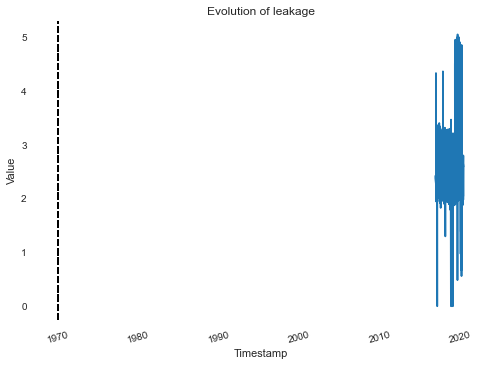

In [40]:
sns.lineplot(x='Timestamp', y='Value',data = df_m2.head(10000))
for xl in df_m2['is_leakage']:
     plt.axvline(x=xl, color='k', linestyle='--')
plt.xticks(rotation=15)
plt.title('Evolution of leakage')
plt.show

In [ ]:
df